# Métricas

Geração de métricas para o experimento da FAST GAN.

# 1. Imports e definições básicas

In [1]:
!git clone https://github.com/heldervj/PyTorch-VAE.git

Cloning into 'PyTorch-VAE'...
remote: Enumerating objects: 905, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 905 (delta 21), reused 27 (delta 13), pack-reused 866
Receiving objects: 100% (905/905), 46.48 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (645/645), done.


In [2]:
cd PyTorch-VAE

/content/PyTorch-VAE


In [3]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-x0tzu_q1
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-x0tzu_q1
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 133 kB 12.0 MB/s 
     |████████████████████████████████| 133 kB 68.3 MB/s 
     |████████████████████████████████| 140 kB 77.5 MB/s 
     |████████████████████████████████| 69 kB 9.3 MB/s 
     |████████████████████████████████| 5.8 MB 58.2 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
     |████████████████████████████████| 419 kB 69.7 MB/s 
     |████████████████████████████████| 286 kB 61.3 MB/s 
     |████████████████████████████████| 54 k

In [4]:
!pip install img2vec-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.5 MB/s 


In [6]:
import torch
import lpips

In [7]:
import os
import psutil
import numpy as np
import pandas as pd
import pickle as pkl
from tqdm import tqdm
import concurrent.futures
from itertools import product
from sklearn.neighbors import NearestNeighbors

class Scores:
    """ 
    Calculates various scoring metrics amongst training, testing and synthetic data files.
    Parameters
    ----------
    train_file : string, required
        The training file to be used.
    test_file : string, required
        The test file to be used.
    synthetic_file: list, required
        The list of various synthetic data files to be used.
    dist_file: string, optional
        The file that containts previously computed distances to omit recalculation.
    workers: int, optional
        The count of workers to use with the default value of 1.
    """
    def __init__(self, train_dataframe, test_dataframe, synthetic_dataframes, dist_file = None, workers = 1):
        """
        Collect all training, testing and synthetic data files for processing
        """

        training_data = train_dataframe.copy()
        training_data = training_data.fillna(training_data.mean())

        testing_data = test_dataframe.copy()
        testing_data = testing_data.fillna(testing_data.mean())

        self.data = {
                        "training_data": training_data, 
                        "testing_data": testing_data
                    }

        self.synth_keys = []
        for i, s in enumerate(synthetic_dataframes):
            self.data[f'synth_{i}'] = s.copy()
            self.synth_keys.append(f'synth_{i}')

        self.distances = {}

        if dist_file is not None:
            self.distances = dist_file
        else:
            self.__compute_nn(workers)

    def __nearest_neighbors(self, t, s):
        # Fit to S
        nn_s = NearestNeighbors(n_neighbors=1, metric='cosine').fit(self.data[s])
        if t == s:
            # Find distances from s to s    
            d = nn_s.kneighbors()[0]
        else:
            # Find distances from t to s
            d = nn_s.kneighbors(self.data[t])[0]
        return t, s, d

    def __compute_nn(self, workers):
        tasks = product(self.data.keys(), repeat=2)

        with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
            futures = [
                executor.submit(self.__nearest_neighbors, t, s)
                for (t, s) in tasks
            ]

            # Wait for each job to finish
            for future in tqdm(concurrent.futures.as_completed(futures),
                                total=len(futures)):
                t, s, d = future.result()
                self.distances[(t, s)] = d

        if not os.path.isdir("gen_data"):
            os.mkdir("gen_data")

        pkl.dump(self.distances, open(f'gen_data/syn_dists.pkl', 'wb'))

    def __discrepancy_score(self, t, s):
        left = np.mean(self.distances[(t, s)])
        right = np.mean(self.distances[(s, t)])
        return 0.5 * (left + right)

    def compute_discrepancy(self):  
        """
        Compute the standard discrepancy scores
        Outputs
        -------
        The discrepency amongst the various data files.
        """
        j_rr = self.__discrepancy_score('training_data', 'testing_data')
        j_ra = []
        j_rat = []
        j_aa = []

        # For all of the synthetic datasets
        for k in self.synth_keys:
            j_ra.append(self.__discrepancy_score('training_data', k))
            j_rat.append(self.__discrepancy_score('testing_data', k))
            # Comparison to other synthetics
            for k_2 in self.synth_keys:
                if k != k_2:
                    j_aa.append(self.__discrepancy_score(k, k_2))

        # Average across synthetics
        j_ra = np.mean(np.array(j_ra))
        j_rat = np.mean(np.array(j_rat))
        j_aa = np.mean(np.array(j_aa))

        print("Discrepency in training and test data is: {}".format(np.round(j_rr, 2)))
        print("Discrepency in training data and synthetic data is: {}".format(np.round(j_ra, 2)))
        print("Discrepency in testing and synthetic data is: {}".format(np.round(j_rat, 2)))
        print("Discrepency amongst various synthetic data files is: {}".format(np.round(j_aa, 2)))

    def __divergence(self, t, s):
        left = np.mean(np.log(self.distances[(t, s)] / self.distances[(t, t)]))
        right = np.mean(np.log(self.distances[(s, t)] / self.distances[(s, s)]))
        return 0.5 * (left + right)

    def compute_divergence(self):
        """
        Compute the divergence scores
        Outputs
        -------
        The divergence score amongst the various data files.
        """
        d_tr_a = []
        d_te_a = []

        for k in self.synth_keys:
            d_tr_a.append(self.__divergence('training_data', k))
            d_te_a.append(self.__divergence('testing_data', k))

        training = np.mean(np.array(d_tr_a))
        testing = np.mean(np.array(d_te_a))

        print("Divergence in training and synthetic data is: {}".format(np.round(training, 2)))
        print("Divergence in testing and synthetic data is: {}".format(np.round(testing, 2)))


    def __adversarial_accuracy(self, t, s):
        left = np.mean(self.distances[(t, s)] > self.distances[(t, t)])
        right = np.mean(self.distances[(s, t)] > self.distances[(s, s)])
        return 0.5 * (left + right)

    def __calculate_accuracy(self):
        """
        Compute the standarad adversarial accuracy scores
        """

        train_accuracy = []
        test_accuracy = []
        for key in self.synth_keys:
            train_accuracy.append(self.__adversarial_accuracy('training_data', key))
            test_accuracy.append(self.__adversarial_accuracy('testing_data', key))

        avg_train_accuracy = np.mean(np.array(train_accuracy))
        avg_test_accuracy = np.mean(np.array(test_accuracy))
        return avg_train_accuracy, avg_test_accuracy

    def calculate_accuracy(self, display=True):
        """
        Compute the standarad adversarial accuracy scores
        Outputs
        -------
        The adversarial accuracy for the two data files along with privacy loss.
        """

        train_acc, test_acc = self.__calculate_accuracy()

        if display:
            print("Adversarial accuracy for train data is: {}".format(np.round(train_acc, 2)))
            print("Adversarial accuracy for test data is: {}".format(np.round(test_acc, 2)))
            print("Privacy Loss is: {}".format(np.round(np.round(test_acc, 2) - np.round(train_acc, 2), 2)))

        return train_acc, test_acc

In [60]:
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from matplotlib import pyplot as plt
from matplotlib import cm

def plot_pca_comp(train_dataframe, test_dataframe, synth_dataframe, scores, title=None, plot_valid=True):

    aa_train, aa_test = scores.calculate_accuracy(display=False)

    pca = PCA(n_components=2)

    train_pca = pca.fit_transform(train_dataframe)
    test_pca = pca.transform(test_dataframe)
    synth_pca = pca.transform(synth_dataframe)

    explained_variance = pca.explained_variance_ratio_.sum()

    if plot_valid:

        fig, ax = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)

        ax[0].scatter(train_pca[:, 0], train_pca[:, 1], label='train_data', facecolors='none', edgecolors='b')
        ax[0].scatter(synth_pca[:, 0], synth_pca[:, 1], label='synth_data', facecolors='none', edgecolors='r')
        ax[0].legend()
        ax[0].set_title(f'PCA - train - AA: {aa_train:.2f}')
        ax[0].set_xlabel('PCA 1')
        ax[0].set_ylabel('PCA 2')

        

        ax[1].scatter(test_pca[:, 0], test_pca[:, 1], label='train_data', facecolors='none', edgecolors='b')
        ax[1].scatter(synth_pca[:, 0], synth_pca[:, 1], label='synth_data', facecolors='none', edgecolors='r')
        ax[1].legend()
        ax[1].set_title(f'PCA - test - AA: {aa_test:.2f}')
        ax[1].set_xlabel('PCA 1')
        ax[1].set_ylabel('PCA 2')

    else:
        fig, ax = plt.subplots(1, 1, figsize=(4, 8), sharex=True, sharey=True)

        ax.scatter(train_pca[:, 0], train_pca[:, 1], label='train_data', facecolors='none', edgecolors='b')
        ax.scatter(synth_pca[:, 0], synth_pca[:, 1], label='valid_data', facecolors='none', edgecolors='r')
        ax.legend()
        ax.set_title(f'PCA - train - AA: {aa_train:.2f}')
        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')

    if title is not None:
        fig.suptitle(f'{title} - {explained_variance*100:.0f}% variância', fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Dataset

In [10]:
!wget http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar

--2022-07-04 23:39:08--  http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2592010240 (2.4G) [application/x-tar]
Saving to: ‘indoorCVPR_09.tar’

indoorCVPR_09.tar   100%[===================>]   2.41G  12.6MB/s    in 3m 36s  

2022-07-04 23:42:44 (11.5 MB/s) - ‘indoorCVPR_09.tar’ saved [2592010240/2592010240]



In [11]:
!tar -xvf ./indoorCVPR_09.tar

A saída de streaming foi truncada nas últimas 5000 linhas.
Images/mall/cover_home3.jpg
Images/mall/CP67791.jpg
Images/mall/crocker_galleria_735089.jpg
Images/mall/mall1.jpg
Images/mall/d8.jpg
Images/mall/deira_city_centre_dubai_08.jpg
Images/mall/dungarv_new_mall.jpg
Images/mall/latham_circle_mall_16.jpg
Images/mall/eastridg1.jpg
Images/mall/IMG_6449.jpg
Images/mall/main_boutique_b.jpg
Images/mall/easyfranchise_centre_commercial_1.jpg
Images/mall/ins42.jpg
Images/mall/mall14.jpg
Images/mall/eaton_centre_2001_03.jpg
Images/mall/ins43.jpg
Images/mall/mall17.jpg
Images/mall/full_shopping_Central_1.jpg
Images/mall/galleria.jpg
Images/mall/galleria1.jpg
Images/mall/galleria2.jpg
Images/mall/Galleria_003.jpg
Images/mall/laurel_mall_06.jpg
Images/mall/Galleria_1.jpg
Images/mall/galleria_san_federico_nr_109_2_n1.jpg
Images/mall/ins23.jpg
Images/mall/ins44.jpg
Images/mall/mall18.jpg
Images/mall/galleria_vittorio_emanuele_ii_milan_mlgalar.jpg
Images/mall/ins45.jpg
Images/mall/mall19.jpg
Images/m

In [12]:
files=[x.split("/")[-1]for x in [x[0] for x in os.walk("Images")][1:]]
files.sort()
labeldict={}
count=0

for file in files:
    labeldict[file]=count
    count+=1
    
from collections import defaultdict
class_freq=defaultdict(int)
csvlist=[]

for file in files:
    images=os.listdir(os.path.join(os.getcwd() + "/Images",file))
    count=1
    for img in images:
        an=img.split(".")        
        newname=str(file)+"_"+str(count)+"."+str(an[-1])
        os.rename(os.path.join(os.getcwd() + "/Images",file,img),os.path.join(os.getcwd() + "/Images",newname))
        csvlist.append([file, labeldict[file],newname])
        class_freq[file]+=1
        count+=1
        
for file in files:
    os.rmdir(os.path.join(os.getcwd() + "/Images",file))

df = pd.DataFrame(csvlist, columns=["Category", "Category_Id","File"]) 
# df.to_csv("Train.csv")
#!mv Train.csv ../Train.csv

In [13]:
!cp -r Images Images_train
!mv Images Images_valid

In [14]:
df_train = pd.read_csv('/content/drive/MyDrive/Train.csv')

for file in os.listdir('Images_train'):
    if file not in df_train['File'].values:
        os.remove(f'Images_train/{file}')

df_train.head()

Unnamed: 0 Category  Category_Id           File
0        2130  bedroom            6  bedroom_1.jpg
1        2131  bedroom            6  bedroom_2.jpg
2        2133  bedroom            6  bedroom_4.jpg
3        2135  bedroom            6  bedroom_6.jpg
4        2136  bedroom            6  bedroom_7.jpg

In [15]:
df_valid = pd.read_csv('/content/drive/MyDrive/Valid.csv')

for file in os.listdir('Images_valid'):
    if file not in df_valid['File'].values:
        os.remove(f'Images_valid/{file}')

df_valid.head()

Unnamed: 0 Category  Category_Id            File
0        2132  bedroom            6   bedroom_3.jpg
1        2134  bedroom            6   bedroom_5.jpg
2        2138  bedroom            6   bedroom_9.jpg
3        2140  bedroom            6  bedroom_11.jpg
4        2145  bedroom            6  bedroom_16.jpg

# 3. FID

In [16]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14835 sha256=a8c74532badb5ee1b866c850fa5503113d55763adbc9f70b373f080415bdf340
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid


In [17]:
!mkdir Images_train_transformed
!mkdir Images_valid_transformed

In [20]:
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

transform_metric = transforms.Compose([
                               transforms.Resize((512, 512)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_path = 'Images_train'
valid_path = 'Images_valid'

images_train = [os.path.join(train_path, image) for image in os.listdir(train_path)]
images_valid = [os.path.join(valid_path, image) for image in os.listdir(valid_path)]

for image in tqdm(images_train):
    image_new = Image.open(image).convert('RGB')
    image_new = transform_metric(image_new)

    save_image(image_new, os.path.join(train_path + '_transformed', image.split('/')[-1]))

for image in tqdm(images_valid):
    image_new = Image.open(image).convert('RGB')
    image_new = transform_metric(image_new)

    save_image(image_new, os.path.join(valid_path + '_transformed', image.split('/')[-1]))

100%|██████████| 331/331 [00:13<00:00, 24.83it/s]


## FID Real (valid)

In [21]:
!python -m pytorch_fid Images_train_transformed/ Images_valid_transformed/ --device cuda:0

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:07<00:00, 12.7MB/s]
100% 7/7 [00:02<00:00,  2.36it/s]
100% 7/7 [00:02<00:00,  2.47it/s]
FID:  63.11149739911053


## FID 10K

In [61]:
!python -m pytorch_fid Images_train_transformed/ /content/drive/MyDrive/eval_10000_662/img/ --device cuda:0

100% 7/7 [00:02<00:00,  2.47it/s]
100% 14/14 [00:11<00:00,  1.25it/s]
FID:  88.53524392978784


In [62]:
!python -m pytorch_fid Images_valid_transformed/ /content/drive/MyDrive/eval_10000_662/img/ --device cuda:0

100% 7/7 [00:02<00:00,  2.43it/s]
100% 14/14 [00:10<00:00,  1.39it/s]
FID:  87.48016407567104


## FID 50K

In [63]:
!python -m pytorch_fid Images_train_transformed/ /content/drive/MyDrive/eval_50000_662/img/ --device cuda:0

100% 7/7 [00:02<00:00,  2.46it/s]
100% 14/14 [00:10<00:00,  1.33it/s]
FID:  75.9555226768303


In [64]:
!python -m pytorch_fid Images_valid_transformed/ /content/drive/MyDrive/eval_50000_662/img/ --device cuda:0

100% 7/7 [00:02<00:00,  2.48it/s]
100% 14/14 [00:11<00:00,  1.21it/s]
FID:  74.36980039175185


## FID 100K

In [65]:
!python -m pytorch_fid Images_train_transformed/ /content/drive/MyDrive/eval_100000_662/img/ --device cuda:0

100% 7/7 [00:02<00:00,  2.42it/s]
100% 14/14 [00:10<00:00,  1.32it/s]
FID:  78.82519462653477


In [66]:
!python -m pytorch_fid Images_valid_transformed/ /content/drive/MyDrive/eval_100000_662/img/ --device cuda:0

100% 7/7 [00:02<00:00,  2.45it/s]
100% 14/14 [00:10<00:00,  1.39it/s]
FID:  77.95493493988204


## FID 150K

In [59]:
!python -m pytorch_fid Images_train_transformed/ /content/drive/MyDrive/eval_150000_662/img/ --device cuda:0

100% 7/7 [00:02<00:00,  2.45it/s]
100% 14/14 [00:15<00:00,  1.14s/it]
FID:  77.40834669684247


In [60]:
!python -m pytorch_fid Images_valid_transformed/ /content/drive/MyDrive/eval_150000_662/img/ --device cuda:0

100% 7/7 [00:02<00:00,  2.44it/s]
100% 14/14 [00:12<00:00,  1.11it/s]
FID:  76.93736495638717


# 4. Adversarial Accuracy e Privacy Loss

In [22]:
from PIL import Image
from skimage import io, transform
from torchvision import transforms
from img2vec_pytorch import Img2Vec

EMBEDDING_SIZE = 512

image = Image.open('Images_train/bedroom_1.jpg').convert('RGB')
# image = transform_resnet(image)
# image = image.unsqueeze(0)


img2vec = Img2Vec(cuda=True)
vec = img2vec.get_vec(image, tensor=True).reshape(EMBEDDING_SIZE)

vec.shape

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([512])

In [23]:
vetores_treino = []

for file in os.listdir('Images_train'):
    image = Image.open(f'Images_train/{file}').convert('RGB')
    vetores_treino.append(img2vec.get_vec(image, tensor=True).reshape(EMBEDDING_SIZE).numpy())

print(len(vetores_treino))

331


In [24]:
vetores_valid = []

for file in os.listdir('Images_valid'):
    image = Image.open(f'Images_valid/{file}').convert('RGB')
    vetores_valid.append(img2vec.get_vec(image, tensor=True).reshape(EMBEDDING_SIZE).numpy())

print(len(vetores_valid))

331


In [25]:
vetores_synth_10 = []

for file in os.listdir('/content/drive/MyDrive/eval_10000_662/img')[:len(vetores_valid)]:
    image = Image.open(f'/content/drive/MyDrive/eval_10000_662/img/{file}').convert('RGB')
    vetores_synth_10.append(img2vec.get_vec(image, tensor=True).reshape(EMBEDDING_SIZE).numpy())

print(len(vetores_synth_10))

331


In [26]:
vetores_synth_50 = []

for file in os.listdir('/content/drive/MyDrive/eval_50000_662/img')[:len(vetores_valid)]:
    image = Image.open(f'/content/drive/MyDrive/eval_50000_662/img/{file}').convert('RGB')
    vetores_synth_50.append(img2vec.get_vec(image, tensor=True).reshape(EMBEDDING_SIZE).numpy())

print(len(vetores_synth_50))

331


In [27]:
vetores_synth_100 = []

for file in os.listdir('/content/drive/MyDrive/eval_100000_662/img')[:len(vetores_valid)]:
    image = Image.open(f'/content/drive/MyDrive/eval_100000_662/img/{file}').convert('RGB')
    vetores_synth_100.append(img2vec.get_vec(image, tensor=True).reshape(EMBEDDING_SIZE).numpy())

print(len(vetores_synth_100))

331


In [28]:
vetores_synth_150 = []

for file in os.listdir('/content/drive/MyDrive/eval_150000_662/img')[:len(vetores_valid)]:
    image = Image.open(f'/content/drive/MyDrive/eval_150000_662/img/{file}').convert('RGB')
    vetores_synth_150.append(img2vec.get_vec(image, tensor=True).reshape(EMBEDDING_SIZE).numpy())

print(len(vetores_synth_150))

331


In [29]:
df_vec_train = pd.DataFrame(vetores_treino)
df_vec_valid = pd.DataFrame(vetores_valid)
df_vec_synth_10 = pd.DataFrame(vetores_synth_10)
df_vec_synth_50 = pd.DataFrame(vetores_synth_50)
df_vec_synth_100 = pd.DataFrame(vetores_synth_100)
df_vec_synth_150 = pd.DataFrame(vetores_synth_150)

print(df_vec_train.shape)
print(df_vec_valid.shape)
print(df_vec_synth_10.shape)
print(df_vec_synth_50.shape)
print(df_vec_synth_100.shape)
print(df_vec_synth_150.shape)

(331, 512)
(331, 512)
(331, 512)
(331, 512)
(331, 512)
(331, 512)


In [53]:
results = pd.DataFrame(index=['AA Train', 'AA Test', 'Privacy Loss', 'Train FID', 'Valid FID'])

100%|██████████| 9/9 [00:00<00:00, 66.51it/s]


Adversarial accuracy for train data is: 0.55
Adversarial accuracy for test data is: 0.0
Privacy Loss is: -0.55


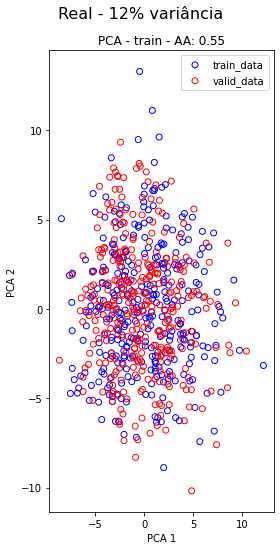

In [61]:
scores_real = Scores(df_vec_train, df_vec_valid, [df_vec_valid])

aa_train_real, aa_test_real = scores_real.calculate_accuracy();

results['REAL'] = [aa_train_real, aa_test_real, aa_test_real - aa_train_real, 0, 63]

plot_pca_comp(df_vec_train, df_vec_valid, df_vec_valid, scores_real, title='Real', plot_valid=False)

100%|██████████| 9/9 [00:00<00:00, 65.13it/s]


Adversarial accuracy for train data is: 0.91
Adversarial accuracy for test data is: 0.91
Privacy Loss is: 0.0


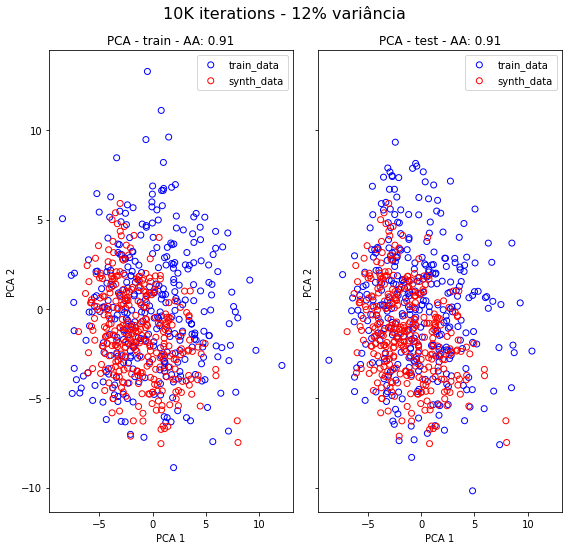

In [55]:
scores_10 = Scores(df_vec_train, df_vec_valid, [df_vec_synth_10])

aa_train_10, aa_test_10 = scores_10.calculate_accuracy();

results['FAST GAN 10K'] = [aa_train_10, aa_test_10, aa_test_10 - aa_train_10, 89, 87]

plot_pca_comp(df_vec_train, df_vec_valid, df_vec_synth_10, scores_10, title='10K iterations')

100%|██████████| 9/9 [00:00<00:00, 67.99it/s]


Adversarial accuracy for train data is: 0.86
Adversarial accuracy for test data is: 0.85
Privacy Loss is: -0.01


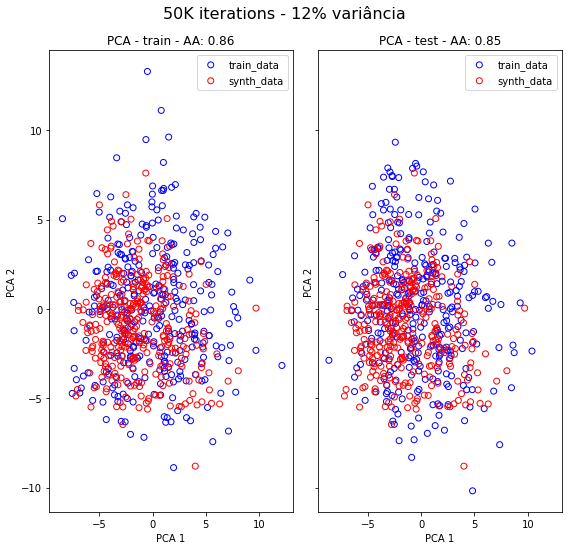

In [56]:
scores_50 = Scores(df_vec_train, df_vec_valid, [df_vec_synth_50])

aa_train_50, aa_test_50 = scores_50.calculate_accuracy();

results['FAST GAN 50K'] = [aa_train_50, aa_test_50, aa_test_50 - aa_train_50, 76, 74]

plot_pca_comp(df_vec_train, df_vec_valid, df_vec_synth_50, scores_50, title='50K iterations')

100%|██████████| 9/9 [00:00<00:00, 64.33it/s]


Adversarial accuracy for train data is: 0.86
Adversarial accuracy for test data is: 0.84
Privacy Loss is: -0.02


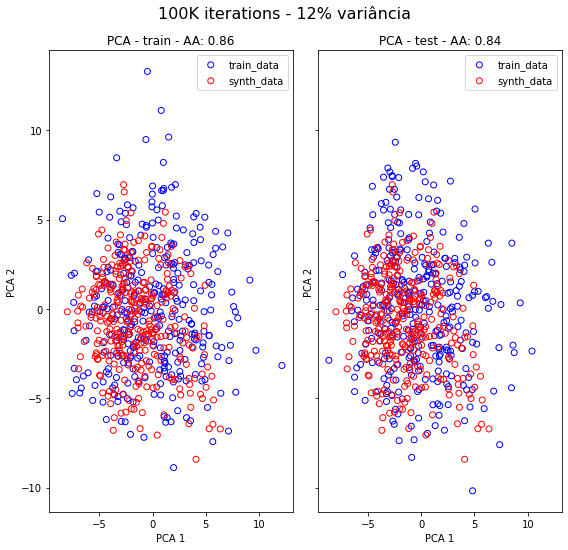

In [57]:
scores_100 = Scores(df_vec_train, df_vec_valid, [df_vec_synth_100])

aa_train_100, aa_test_100 = scores_100.calculate_accuracy();

results['FAST GAN 100K'] = [aa_train_100, aa_test_100, aa_test_100 - aa_train_100, 79, 78]

plot_pca_comp(df_vec_train, df_vec_valid, df_vec_synth_100, scores_100, title='100K iterations')

100%|██████████| 9/9 [00:00<00:00, 71.89it/s]


Adversarial accuracy for train data is: 0.86
Adversarial accuracy for test data is: 0.85
Privacy Loss is: -0.01


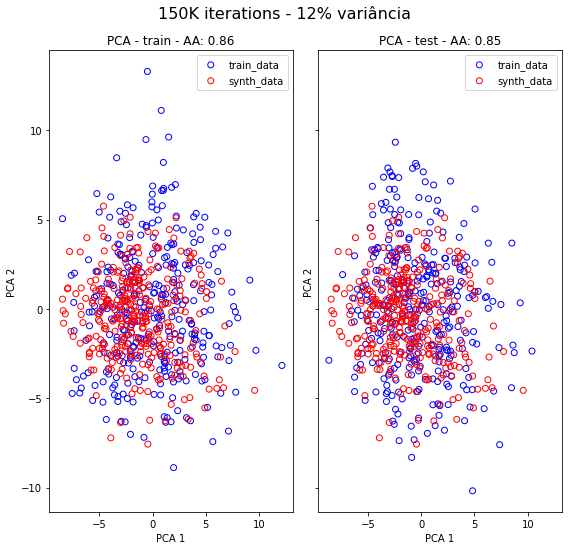

In [58]:
scores_150 = Scores(df_vec_train, df_vec_valid, [df_vec_synth_150])

aa_train_150, aa_test_150 = scores_150.calculate_accuracy();

results['FAST GAN 150K'] = [aa_train_150, aa_test_150, aa_test_150 - aa_train_150, 77, 77]

plot_pca_comp(df_vec_train, df_vec_valid, df_vec_synth_150, scores_150, title='150K iterations')

In [59]:
results.to_latex(float_format='%.2f')

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  FAST GAN REAL &  FAST GAN 10K &  FAST GAN 50K &  FAST GAN 100K &  FAST GAN 150K \\\\\n\\midrule\nAA Train     &           0.55 &          0.91 &          0.86 &           0.86 &           0.86 \\\\\nAA Test      &           0.00 &          0.91 &          0.85 &           0.84 &           0.85 \\\\\nPrivacy Loss &          -0.55 &          0.00 &         -0.01 &          -0.02 &          -0.01 \\\\\nTrain FID    &           0.00 &         89.00 &         76.00 &          79.00 &          77.00 \\\\\nValid FID    &          63.00 &         87.00 &         74.00 &          78.00 &          77.00 \\\\\n\\bottomrule\n\\end{tabular}\n'

# 5. Análises qualitativas imagens

In [62]:
image_1 = lpips.im2tensor(lpips.load_image('/content/drive/MyDrive/eval_150000_662/img/151.png'))
image_2 = lpips.im2tensor(lpips.load_image('/content/drive/MyDrive/eval_150000_662/img/1.png'))

loss_fn = lpips.LPIPS(net='alex').to('cuda:0')
d = loss_fn.forward(image_1.to('cuda:0'), image_2.to('cuda:0'))

d

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


tensor([[[[0.8545]]]], device='cuda:0', grad_fn=<AddBackward0>)

In [27]:
loss_fn.forward(image_1.to('cuda:0'), image_2.to('cuda:0'))

tensor([[[[0.8545]]]], device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
%%timeit 

dist = loss_fn.forward(image_1.to('cuda:0'), image_2.to('cuda:0'))

100 loops, best of 5: 7.22 ms per loop


In [63]:
from torchvision import transforms

transform_metric = transforms.Compose([
                               transforms.Resize((1024, 1024)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

def get_distance(img1, img2, distance='LPIPS'):

    if distance == 'LPIPS':
        image_ref = Image.open(img1).convert('RGB')
        image_ref = transform_metric(image_ref)


        img = Image.open(img2).convert('RGB')
        img = transform_metric(img)
        dist = loss_fn.forward(image_ref.to('cuda:0'), img.to('cuda:0'))

        del image_ref
        del img

        return img1, img2, dist

    elif distance == 'cosine':
        img1 = Image.open(img1).convert('RGB')
        img2 = Image.open(img2).convert('RGB')


        im1_vec = img2vec.get_vec(img1, tensor=True).reshape(EMBEDDING_SIZE)
        im2_vec = img2vec.get_vec(img2, tensor=True).reshape(EMBEDDING_SIZE)

        dist = 1 - cosine_similarity(im1_vec.reshape(1, -1), im2_vec.reshape(1, -1))

        return img1, img2, dist 

In [25]:
from PIL import Image

path_train = 'Images_train/'
path_valid = 'Images_valid/'
path_synth = '/content/drive/MyDrive/eval_150000_662/img'

images_train = [os.path.join(path_train, image) for image in os.listdir(path_train)]
images_valid = [os.path.join(path_valid, image) for image in os.listdir(path_valid)]
images_synth = [os.path.join(path_synth, image) for image in os.listdir(path_synth)][:len(images_valid)]

data = {
    'training_data': images_train,
    'testing_data': images_valid,
    'synth_data': images_synth,
}

distances = [
         ('training_data', 'synth_data'),
         ('training_data', 'training_data'),
         ('synth_data', 'synth_data'),
         ('testing_data', 'synth_data'),
         ('testing_data', 'testing_data'),
         ]

distances_matrix = {}

for set_1, set_2 in distances:
    print(set_1, set_2)

    tasks = product(data[set_1], data[set_2])

    distances_matrix[(set_1, set_2)] = np.zeros((len(images_train), len(images_train)))

    for (t, s) in tqdm(tasks, total=len(images_train)**2):
        t, s, d = get_distance(t, s)
        distances_matrix[(set_1, set_2)][data[set_1].index(t), data[set_2].index(s)] = d

for key in distances_matrix:
    for i in range(len(distances_matrix[key])):
        distances_matrix[key][i, i] = 99999.

import pickle

pickle.dump(distances_matrix, open('/content/drive/MyDrive/distances_matrix.pkl', 'wb'))

training_data synth_data


100%|██████████| 109561/109561 [2:54:05<00:00, 10.49it/s]


training_data training_data


100%|██████████| 109561/109561 [2:44:28<00:00, 11.10it/s]


synth_data synth_data


100%|██████████| 109561/109561 [3:02:12<00:00, 10.02it/s]


testing_data synth_data


100%|██████████| 109561/109561 [3:01:02<00:00, 10.09it/s]


testing_data testing_data


100%|██████████| 109561/109561 [3:05:44<00:00,  9.83it/s]


In [91]:
distances_param = [
    ('training_data', 'synth_0'),
    ('synth_0', 'training_data'),
    ('training_data', 'training_data'),
    ('synth_0', 'synth_0'),
    ('testing_data', 'synth_0'),
    ('synth_0', 'testing_data'),
    ('testing_data', 'testing_data'),        
]

distances_dict = {}

for t, s in distances_param:
    new_t = t
    new_s = s
    if t == 'synth_0':
        new_t = 'synth_data'
    if s == 'synth_0':
        new_s = 'synth_data'

    if (new_t, new_s) in distances:
        distances_dict[(t, s)] = distances_matrix[(new_t, new_s)].min(1).reshape(-1, 1)
    else:
        distances_dict[(t, s)] = distances_matrix[(new_s, new_t)].min(0).reshape(-1, 1)

Adversarial accuracy for train data is: 0.76
Adversarial accuracy for test data is: 0.77
Privacy Loss is: 0.01


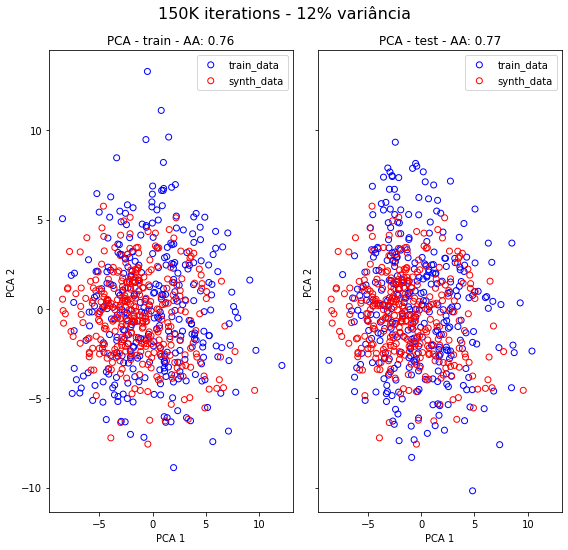

In [97]:
scores_150 = Scores(df_vec_train, df_vec_valid, [df_vec_synth_150], dist_file=distances_dict)

aa_train_150, aa_test_150 = scores_150.calculate_accuracy();

results['FAST GAN 150K'] = [aa_train_150, aa_test_150, aa_test_150 - aa_train_150, 77, 77]

plot_pca_comp(df_vec_train, df_vec_valid, df_vec_synth_150, scores_150, title='150K iterations')

In [49]:
distances_matrix[('training_data', 'synth_data')]

0.664581612697901

In [24]:
images_train

['Images_train/bedroom_358.jpg',
 'Images_train/bedroom_647.jpg',
 'Images_train/bedroom_462.jpg',
 'Images_train/bedroom_110.jpg',
 'Images_train/bedroom_425.jpg',
 'Images_train/bedroom_365.jpg',
 'Images_train/bedroom_410.jpg',
 'Images_train/bedroom_278.jpg',
 'Images_train/bedroom_227.jpg',
 'Images_train/bedroom_544.jpg',
 'Images_train/bedroom_51.jpg',
 'Images_train/bedroom_311.jpg',
 'Images_train/bedroom_428.jpg',
 'Images_train/bedroom_623.jpg',
 'Images_train/bedroom_501.jpg',
 'Images_train/bedroom_95.jpg',
 'Images_train/bedroom_312.jpg',
 'Images_train/bedroom_364.jpg',
 'Images_train/bedroom_617.jpg',
 'Images_train/bedroom_153.jpg',
 'Images_train/bedroom_475.jpg',
 'Images_train/bedroom_369.jpg',
 'Images_train/bedroom_217.jpg',
 'Images_train/bedroom_169.jpg',
 'Images_train/bedroom_595.jpg',
 'Images_train/bedroom_112.jpg',
 'Images_train/bedroom_561.jpg',
 'Images_train/bedroom_258.jpg',
 'Images_train/bedroom_296.jpg',
 'Images_train/bedroom_558.jpg',
 'Images_tra

In [64]:
def most_similar_training_image(image_ref, n=1, distance='LPIPS', path_dataset='Images_train'):

    distances = []

    for idx, img_file in tqdm(enumerate(os.listdir(path_dataset)), total=len(os.listdir(path_dataset))):
        img_file = f'{path_dataset}/{img_file}'
        _, _, dist = get_distance(image_ref, img_file, distance=distance)
        distances.append((img_file, dist))


    distances = sorted(distances, key= lambda x: x[1])

    return distances[:n]

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, distance='lpips'):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(18, 10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(distance)


In [66]:
def plot_images(image_ref, DISTANCE, N):
    transform_plot = transforms.Compose([
                               transforms.Resize((512, 512)),
                               transforms.ToTensor(),
                           ])

    image_ref_tensor = transform_plot(Image.open(image_ref).convert('RGB'))
    # display(Image.open(image_ref).convert('RGB'))

    most_similars = most_similar_training_image(image_ref, n=N, distance=DISTANCE)

    images_plot = []

    for idx, results in enumerate(most_similars):
        img_file, dist = results
        images_plot.append(transform_plot(Image.open(img_file).convert('RGB')))
        # display(Image.open(img_file).convert('RGB'))

    show(make_grid(torch.stack([image_ref_tensor] + images_plot)), distance=DISTANCE)

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import display

100%|██████████| 331/331 [00:14<00:00, 22.52it/s]


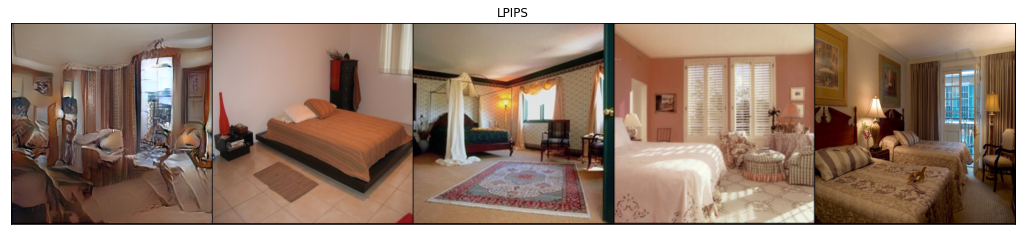

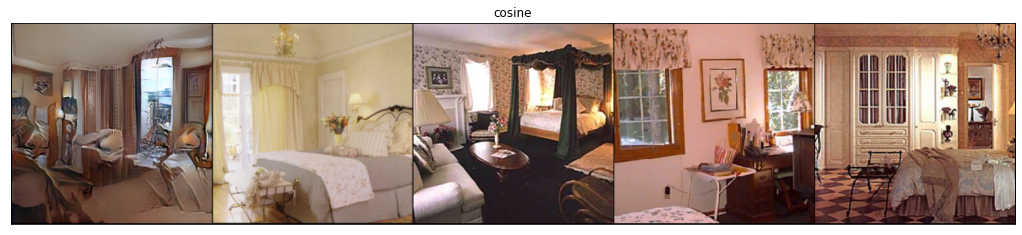

In [70]:
image_ref = '/content/drive/MyDrive/eval_150000_662/img/19.png'
N = 4

plot_images(image_ref, 'LPIPS', N)
plot_images(image_ref, 'cosine', N)

100%|██████████| 331/331 [00:12<00:00, 26.20it/s]


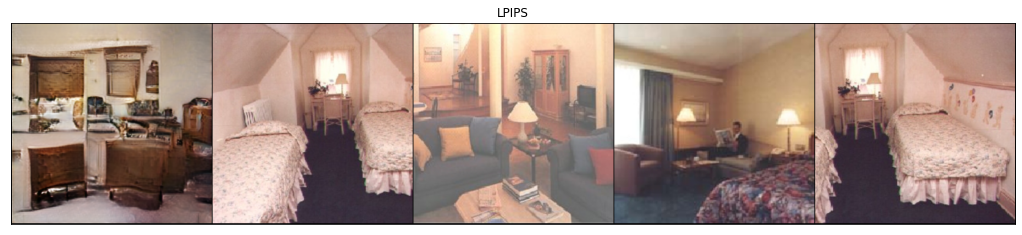

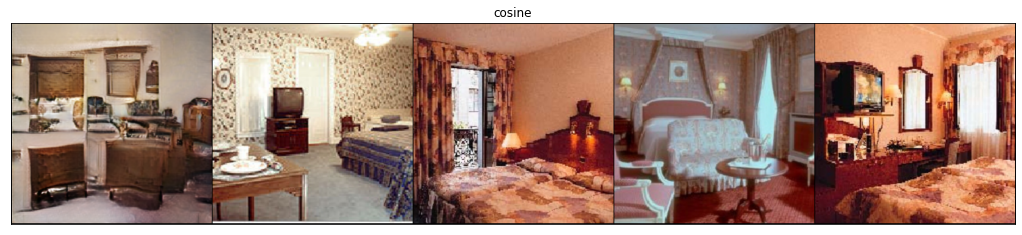

In [71]:
image_ref = '/content/drive/MyDrive/eval_150000_662/img/112.png'
N = 4

plot_images(image_ref, 'LPIPS', N)
plot_images(image_ref, 'cosine', N)

100%|██████████| 331/331 [00:13<00:00, 25.36it/s]


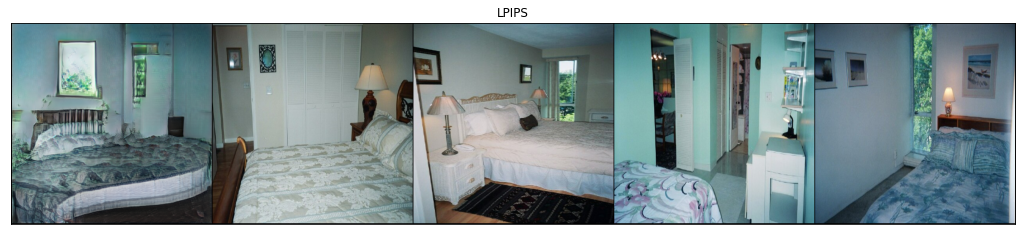

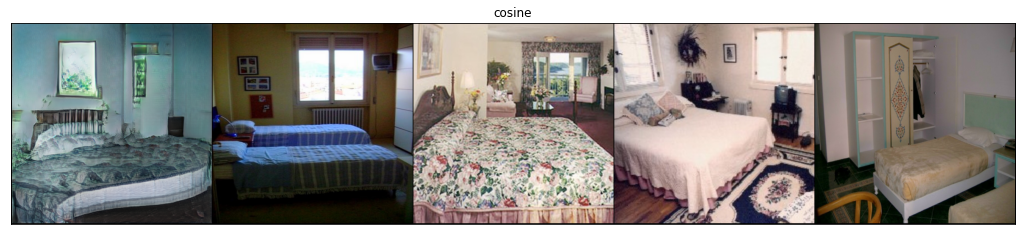

In [72]:
image_ref = '/content/drive/MyDrive/eval_150000_662/img/15.png'
N = 4

plot_images(image_ref, 'LPIPS', N)
plot_images(image_ref, 'cosine', N)

100%|██████████| 331/331 [00:12<00:00, 25.49it/s]


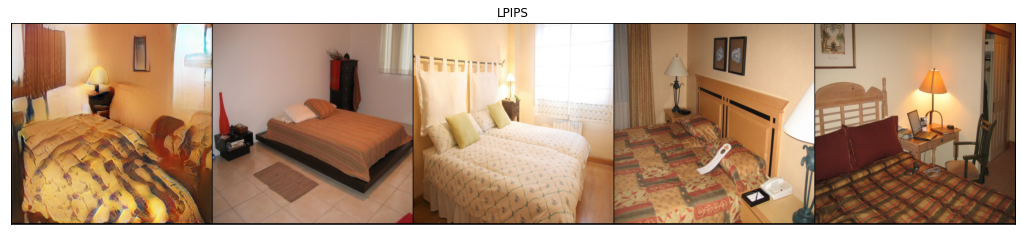

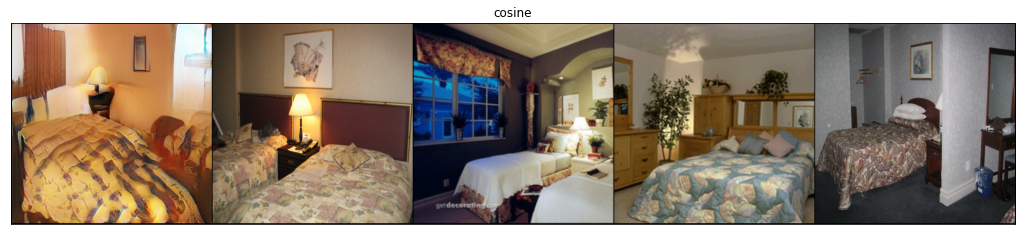

In [73]:
image_ref = '/content/drive/MyDrive/eval_150000_662/img/331.png'
N = 4

plot_images(image_ref, 'LPIPS', N)
plot_images(image_ref, 'cosine', N)

100%|██████████| 331/331 [00:12<00:00, 26.68it/s]


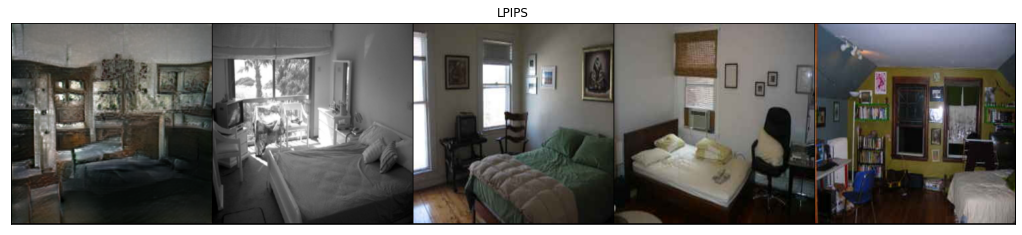

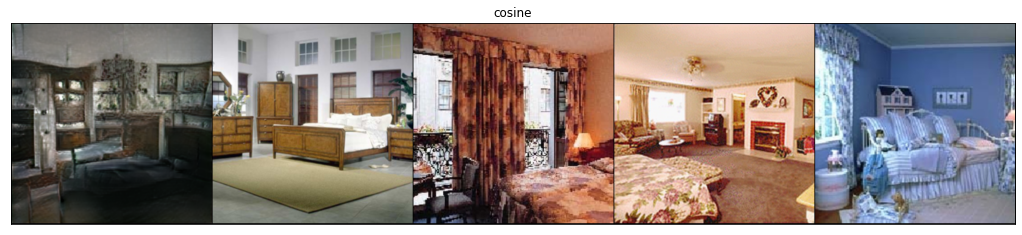

In [74]:
image_ref = '/content/drive/MyDrive/eval_150000_662/img/212.png'
N = 4

plot_images(image_ref, 'LPIPS', N)
plot_images(image_ref, 'cosine', N)

100%|██████████| 331/331 [00:12<00:00, 25.89it/s]


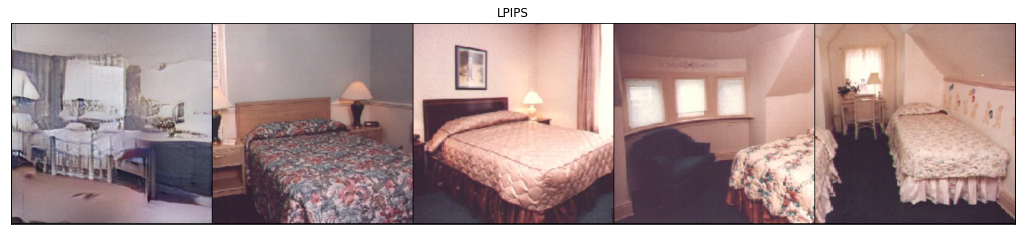

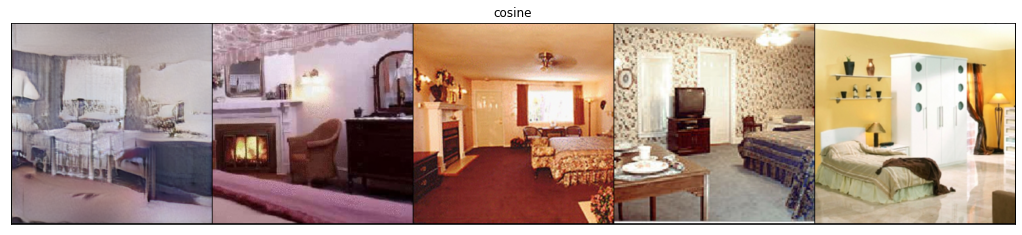

In [76]:
image_ref = '/content/drive/MyDrive/eval_150000_662/img/12.png'
N = 4

plot_images(image_ref, 'LPIPS', N)
plot_images(image_ref, 'cosine', N)

100%|██████████| 331/331 [00:12<00:00, 26.55it/s]


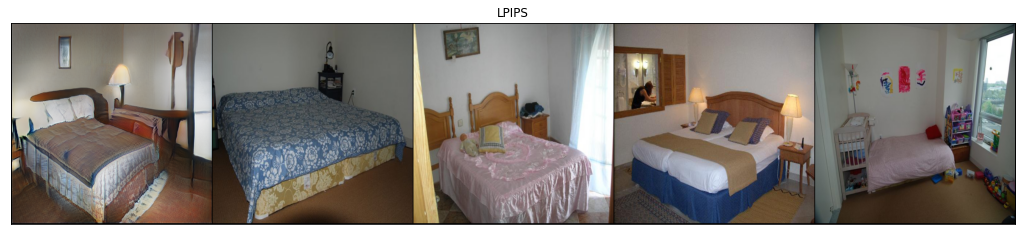

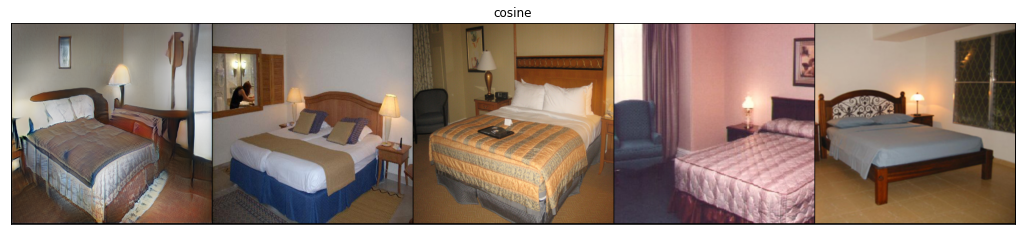

In [70]:
image_ref = '/content/drive/MyDrive/eval_150000_662/img/587.png'
N = 4

plot_images(image_ref, 'LPIPS', N)
plot_images(image_ref, 'cosine', N)

In [136]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import display

image_ref = '/content/drive/MyDrive/eval_150000_662/img/19.png'
DISTANCE = 'LPIPS'

transform_plot = transforms.Compose([
                               transforms.Resize((512, 512)),
                               transforms.ToTensor(),
                           ])

image_ref_tensor = transform_plot(Image.open(image_ref).convert('RGB'))
# display(Image.open(image_ref).convert('RGB'))

most_similars = most_similar_training_image(image_ref, n=4, distance=DISTANCE, path_dataset='Images_valid')

images_plot = []

for idx, results in enumerate(most_similars):
    img_file, dist = results
    images_plot.append(transform_plot(Image.open(img_file).convert('RGB')))
    # display(Image.open(img_file).convert('RGB'))

show(make_grid(torch.stack([image_ref_tensor] + images_plot)), distance=DISTANCE)

  0%|          | 0/331 [00:00<?, ?it/s]


RuntimeError: ignored